In [79]:
### rdflib library
from rdflib import Graph, URIRef, Literal
from rdflib.namespace import RDFS, XSD, FOAF, GEO, DCTERMS, PROV, RDF, SKOS, SOSA, SSN, TIME, XSD, SDO, QB
from rdflib.plugins.sparql.processor import SPARQLResult
from rdflib import Namespace
from rdflib.tools.rdf2dot import rdf2dot
### other rdf library
from rdfpandas.graph import to_graph
from rdfpandas.graph import to_dataframe
### standard libraries
import pandas as pd
import numpy as np 
import re
import io
### libraries for visualizing graphs
import pydotplus
from IPython.display import display, Image


In [61]:
#### function to return sparql results into df
def sparql_results_to_df(results: SPARQLResult) -> pd.DataFrame:
    """
    Export results from an rdflib SPARQL query into a `pandas.DataFrame`,
    using Python types. See https://github.com/RDFLib/rdflib/issues/1179.
    """
    return pd.DataFrame(
        data=([None if x is None else x.toPython() for x in row] for row in results),
        columns=[str(x) for x in results.vars],                
    )
#### function to visualize graph
def visualize(g):
    stream = io.StringIO()
    rdf2dot(g, stream, opts = {display})
    dg = pydotplus.graph_from_dot_data(stream.getvalue())
    png = dg.create_png()
    display(Image(png))

In [62]:
### definition of namespaces variables
FOODIE = Namespace("http://foodie-cloud.com/model/foodie#")
S4AGRI = Namespace("https://saref.etsi.org/saref4agri/")
SDM = Namespace("https://smartdatamodels.org/")
SDMAGRI = Namespace("https://smartdatamodels.org/dataModel.Agrifood/")
PLOUTOS = Namespace("https://www.tno.nl/agrifood/ontology/ploutos/common#")
QUDT = Namespace("http://qudt.org/schema/qudt/")

g = Graph()
g.bind("foaf", FOAF)
g.bind("dct", DCTERMS)
g.bind("sosa", SOSA)
g.bind("foodie", FOODIE)
g.bind("s4agri", S4AGRI)
g.bind("sdm", SDM)
g.bind("sdmagri", SDMAGRI)
g.bind("ploutos", PLOUTOS)
g.bind("qudt", QUDT)

### define simple json-ld example
json_ld_data_string = """
{
  "@context": {
    "dct": "http://purl.org/dc/terms/",
    "sdo": "https://schema.org/"
  },
  "@graph": [
    {
      "@id": "https://kurrawong.ai",
      "@type": [
        "dct:Agent",
        "sdo:Organization"
      ],
      "sdo:name": "KurrawongAI"
    },
    {
      "@id": "http://example.com/person/nick",
      "@type": "dct:Agent",
      "sdo:memberOf": {
        "@id": "https://kurrawong.ai"
      },
      "sdo:name": "Nicholas Car"
    }
  ]
}
"""

In [63]:
### load simple json-ld example in graph
g.parse(data=json_ld_data_string, format="json-ld")
print ("### print graph triple by triple:")
for s, p, o in g:
    print(s, p, o)


### print graph triple by triple:
http://example.com/person/nick https://schema.org/name Nicholas Car
http://example.com/person/nick http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://purl.org/dc/terms/Agent
https://kurrawong.ai http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://purl.org/dc/terms/Agent
http://example.com/person/nick https://schema.org/memberOf https://kurrawong.ai
https://kurrawong.ai http://www.w3.org/1999/02/22-rdf-syntax-ns#type https://schema.org/Organization
https://kurrawong.ai https://schema.org/name KurrawongAI


In [64]:
### serialize graph as turtle
print ("### print graph as turtle:")
print(g.serialize(format='turtle'))


### print graph as turtle:
@prefix dct: <http://purl.org/dc/terms/> .
@prefix sdo: <https://schema.org/> .

<http://example.com/person/nick> a dct:Agent ;
    sdo:memberOf <https://kurrawong.ai> ;
    sdo:name "Nicholas Car" .

<https://kurrawong.ai> a dct:Agent,
        sdo:Organization ;
    sdo:name "KurrawongAI" .




In [66]:
### make query over the graph and load as dataframe
pd.options.display.max_colwidth = None
#pd.options.display.max_columns = None

result = g.query("select * {?s ?p ?o}")
df = sparql_results_to_df(result)    
df = df[['s', 'p', 'o']]
print ("### print results of query as dataframe:")
print (df.to_string())

### print results of query as dataframe:
                                s                                                p                                o
0  http://example.com/person/nick                          https://schema.org/name                     Nicholas Car
1  http://example.com/person/nick  http://www.w3.org/1999/02/22-rdf-syntax-ns#type   http://purl.org/dc/terms/Agent
2            https://kurrawong.ai  http://www.w3.org/1999/02/22-rdf-syntax-ns#type   http://purl.org/dc/terms/Agent
3  http://example.com/person/nick                      https://schema.org/memberOf             https://kurrawong.ai
4            https://kurrawong.ai  http://www.w3.org/1999/02/22-rdf-syntax-ns#type  https://schema.org/Organization
5            https://kurrawong.ai                          https://schema.org/name                      KurrawongAI


In [67]:
### use to_dataframe library -- not very useful
df1 = to_dataframe(g)
print ("### print to_dataframe result:") 
print (df1.to_string())
#print (df1.columns)


### print to_dataframe result:
                               rdf:type{URIRef}[0] rdf:type{URIRef}[1]  sdo:memberOf{URIRef} sdo:name{Literal}
http://example.com/person/nick           dct:Agent                 NaN  https://kurrawong.ai      Nicholas Car
https://kurrawong.ai                     dct:Agent    sdo:Organization                   NaN       KurrawongAI


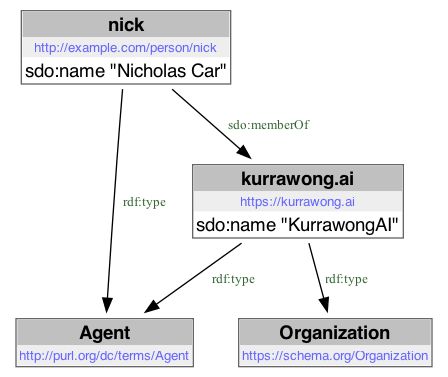

In [ ]:
### visualize the small graph
visualize(g)

In [81]:
### load OCSM json-ld examples
g = Graph()
g.parse("https://raw.githubusercontent.com/openagri-eu/OCSM/refs/heads/main/examples/pestManagement_v2.jsonld")

### load all data to dataframe
result = g.query("select * {?s ?p ?o}")
df = sparql_results_to_df(result)    
df = df[['s', 'p', 'o']]
print ("### ocsm example dataframe:")
print (df.to_string())

### ocsm example dataframe:
                                                                        s                                                                       p                                                                                 o
0              urn:openagri:pestMgmt:3452532c-76b8-4850-8f06-5d08fc2a6356                         http://www.w3.org/1999/02/22-rdf-syntax-ns#type      https://www.tno.nl/agrifood/ontology/ploutos/common#ChemicalControlOperation
1              urn:openagri:pestMgmt:1fbe948f-973b-401b-b597-ef4c4a71513d                         http://www.w3.org/1999/02/22-rdf-syntax-ns#type      https://www.tno.nl/agrifood/ontology/ploutos/common#ChemicalControlOperation
2       urn:openagri:pestMgmt:amount:ce48c68f-acb5-4e12-8f1f-1254e5857be6                         http://www.w3.org/1999/02/22-rdf-syntax-ns#type                                         http://qudt.org/schema/qudt/QuantityValue
3              urn:openagri:pestMgmt:b78a41a0-033d-44da-902a

In [82]:
### use local names for URLs in dataframe
df['p'] = df['p'].str.extract('.*[/|#](.*)$')
df['o'] = df['o'].apply(lambda x: re.split('.*[/|#](.*)$', str(x))[1] if 'http' in str(x) else x)
print ("### ocsm example dataframe using localnames:")
print (df.to_string())

### ocsm example dataframe using localnames:
                                                                        s                   p                                                                     o
0              urn:openagri:pestMgmt:3452532c-76b8-4850-8f06-5d08fc2a6356                type                                              ChemicalControlOperation
1              urn:openagri:pestMgmt:1fbe948f-973b-401b-b597-ef4c4a71513d                type                                              ChemicalControlOperation
2       urn:openagri:pestMgmt:amount:ce48c68f-acb5-4e12-8f1f-1254e5857be6                type                                                         QuantityValue
3              urn:openagri:pestMgmt:b78a41a0-033d-44da-902a-7f4903b599f5   isTargetedTowards                                                           Prays Oleae
4       urn:openagri:pestMgmt:amount:b96e4c35-b530-4d30-84a0-a2da50836f98        numericValue                                          

In [83]:
#### get all information about specific operation
operation_id = "urn:openagri:pestMgmt:1fc4d46f-3410-4fc3-9699-05c068e41044"
print(df.loc[df['s'] == operation_id].to_string())

                                                              s                  p                                                                     o
5    urn:openagri:pestMgmt:1fc4d46f-3410-4fc3-9699-05c068e41044  isTargetedTowards                                                        Powdery mildew
8    urn:openagri:pestMgmt:1fc4d46f-3410-4fc3-9699-05c068e41044   hasAppliedAmount     urn:openagri:pestMgmt:amount:b9c756ba-5bd9-497d-b321-6f6d0efe79a6
25   urn:openagri:pestMgmt:1fc4d46f-3410-4fc3-9699-05c068e41044        description                                                 treatment description
28   urn:openagri:pestMgmt:1fc4d46f-3410-4fc3-9699-05c068e41044      usesPesticide  urn:openagri:pestMgmt:pesticide:412ba4eb-adda-4cb3-b01a-554c9e6ddd26
127  urn:openagri:pestMgmt:1fc4d46f-3410-4fc3-9699-05c068e41044       isOperatedOn              urn:openagri:parcel:72d9fb43-53f8-4ec8-a33c-fa931360259a
148  urn:openagri:pestMgmt:1fc4d46f-3410-4fc3-9699-05c068e41044               type

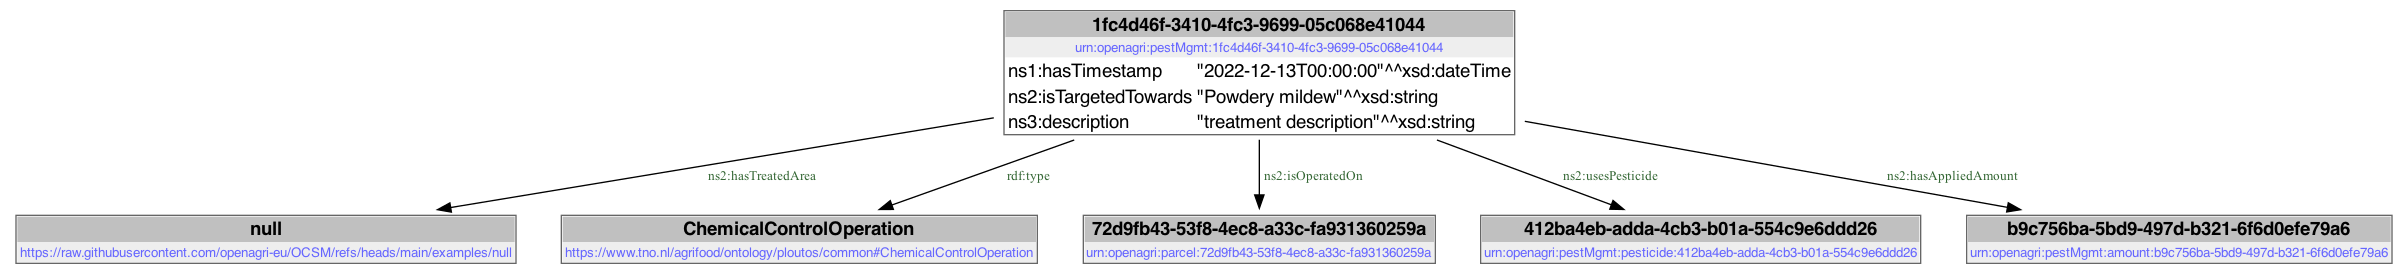

In [112]:
### display one operation
g_res = Graph()
result = g.query("describe <urn:openagri:pestMgmt:1fc4d46f-3410-4fc3-9699-05c068e41044>")
for row in result:
    g_res.add(row)
visualize(g_res)

In [110]:
#### get all operations that used pesticide with specific active sustance
active_sustance = "Bordeaux mixture"
pesticideObj = df.loc[(df['p'] == "hasActiveSubstance") & (df['o'] == active_sustance), 's']
print(df.loc[df['o'].isin(pesticideObj), 's'].to_string())


28     urn:openagri:pestMgmt:1fc4d46f-3410-4fc3-9699-05c068e41044
128    urn:openagri:pestMgmt:2ba53329-612c-47f3-a7f9-67f5f74f98f0


In [ ]:
### query the original graph to filter data
query = "PREFIX ploutos: <https://www.tno.nl/agrifood/ontology/ploutos/common#> \
         PREFIX foodie: <http://foodie-cloud.com/model/foodie#> \
         PREFIX qudt: <http://qudt.org/schema/qudt/> \
         SELECT ?operation_id ?operation_description ?amount_value ?uom ?pesticide_name \
         WHERE {?operation_id a ploutos:ChemicalControlOperation ; \
                                foodie:description ?operation_description ; \
                                ploutos:hasAppliedAmount ?amount ; \
                                ploutos:usesPesticide ?pesticide . \
                ?amount qudt:numericValue ?amount_value; \
                        qudt:unit ?uom . \
                ?pesticide ploutos:hasCommercialName ?pesticide_name\
        }"
result = g.query(query)
df = sparql_results_to_df(result)    
print ("### ocsm SPARQL query results:")
print (df.to_string())

### ocsm SPARQL query results:
                                                  operation_id  operation_description  amount_value                            uom                     pesticide_name
0   urn:openagri:pestMgmt:2ba53329-612c-47f3-a7f9-67f5f74f98f0  treatment description        1176.0  http://qudt.org/vocab/unit/GM                    BORDELESA 20 WP
1   urn:openagri:pestMgmt:51527cd3-f607-458d-9872-9996a7f2fff3  treatment description         588.0  http://qudt.org/vocab/unit/GM                  KOCIDE 2000 35 WG
2   urn:openagri:pestMgmt:1fbe948f-973b-401b-b597-ef4c4a71513d  treatment description         470.0  http://qudt.org/vocab/unit/GM                        COMET 20 EC
3   urn:openagri:pestMgmt:a6472cf0-83cd-4820-a0b6-d50621798a9f  treatment description         200.0  http://qudt.org/vocab/unit/GM                     TRIMANOC 75 WG
4   urn:openagri:pestMgmt:f37a1f97-db50-4aa4-b527-4d217906cd2d  treatment description         150.0  http://qudt.org/vocab/unit/GM         

In [72]:
### query the graph to filter data adding additional graphs
g.parse("https://qudt.org/2.1/vocab/unit")
query = "PREFIX ploutos: <https://www.tno.nl/agrifood/ontology/ploutos/common#> \
         PREFIX foodie: <http://foodie-cloud.com/model/foodie#> \
         PREFIX qudt: <http://qudt.org/schema/qudt/> \
         PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> \
         SELECT ?operation_id ?operation_description ?amount_value ?uom_label ?pesticide_name \
         WHERE {?operation_id a ploutos:ChemicalControlOperation ; \
                                foodie:description ?operation_description ; \
                                ploutos:hasAppliedAmount ?amount ; \
                                ploutos:usesPesticide ?pesticide . \
                ?amount qudt:numericValue ?amount_value; \
                        qudt:unit ?uom . \
                ?uom rdfs:label ?uom_label . \
                ?pesticide ploutos:hasCommercialName ?pesticide_name\
        }"

result = g.query(query)
df = sparql_results_to_df(result)    
print ("### ocsm SPARQL query results with units names:")
print (df.to_string())

### ocsm SPARQL query results with units names:
                                                  operation_id  operation_description  amount_value uom_label                     pesticide_name
0   urn:openagri:pestMgmt:2ba53329-612c-47f3-a7f9-67f5f74f98f0  treatment description        1176.0      Gram                    BORDELESA 20 WP
1   urn:openagri:pestMgmt:51527cd3-f607-458d-9872-9996a7f2fff3  treatment description         588.0      Gram                  KOCIDE 2000 35 WG
2   urn:openagri:pestMgmt:1fbe948f-973b-401b-b597-ef4c4a71513d  treatment description         470.0      Gram                        COMET 20 EC
3   urn:openagri:pestMgmt:a6472cf0-83cd-4820-a0b6-d50621798a9f  treatment description         200.0      Gram                     TRIMANOC 75 WG
4   urn:openagri:pestMgmt:f37a1f97-db50-4aa4-b527-4d217906cd2d  treatment description         150.0      Gram                      SYLLIT 544 SC
5   urn:openagri:pestMgmt:0fb3593a-05ff-410a-a948-8c35a9009105  treatment descript